# Hyperbolic Mohr-Coulomb criterion

__*Load some Python modules*__

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from math import *
from collections import OrderedDict

__*Update some rcParams*__

In [2]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
    "text.latex.preamble":r"\usepackage[T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage{amsmath}\usepackage{amssymb}\usepackage{amsfonts}\usepackage{fourier}",
    "font.size":18,
    'figure.constrained_layout.use':True,
    'figure.constrained_layout.h_pad':.25,
    'figure.constrained_layout.w_pad':.25,
})

__*Define the color map for the figures*__

In [3]:
MyCMap=plt.get_cmap("jet")
MyCMapUP=MyCMap(np.arange(MyCMap.N))

__*Define a dictionary with the default values of the material parameters*__

In [4]:
DefaultDicPara=OrderedDict()
DefaultDicPara["FrictionAngle"]=32.07
DefaultDicPara["DilationAngle"]=32.07
DefaultDicPara["Cohesion"]=4.21
DefaultDicPara["TensionCutOff"]=DefaultDicPara["Cohesion"]/tan(DefaultDicPara["FrictionAngle"]*pi/180.)/20.
DefaultDicPara["PiShapeCoef"]=.99

__*Define a function for the hyperbolic Mohr-Coulomb plastic criterion*__
$$F(\boldsymbol{\sigma})\mathrel{\mathop:}= \frac{I_1}{3}\sin{\varphi}+\sqrt{J_2{K_F(\theta)}^2+a^2\sin^2{\varphi}}-C\cos{\varphi},\quad I_1=\sigma_{kk},\quad J_2=\frac{1}{2}\left(\boldsymbol{\sigma_d}:\boldsymbol{\sigma_d}\right),\quad \boldsymbol{\sigma_d}=\mathbb{K}:\boldsymbol{\sigma}$$
__*With*__
$$K_F(\theta)=K_{F,m}\cos\left(\frac{\beta_F\pi}{6}-\frac{\cos^{-1}\left(\gamma\cos{3\theta}\right)}{3}\right),\quad \beta_F=\frac{6}{\pi}\tan^{-1}\left(\frac{2r_F-1}{\sqrt{3}}\right),\quad r_F=\frac{3-\sin{\varphi}}{3+\sin{\varphi}},\quad K_{F,m}=\frac{\cos{\theta_{F,m}}-\frac{\sin{\varphi}}{\sqrt{3}}\sin{\theta_{F,m}}}{\cos\left(\frac{\beta_F\pi}{6}-\frac{\cos^{-1}{\left(\gamma\cos{\left(3\left(\theta_{F,m}+\frac{\pi}{6}\right)\right)}\right)}}{3}\right)},\quad \theta_{F,m}=\tan^{-1}{\left(-\frac{\sin{\varphi}}{\sqrt{3}}\right)}$$

In [5]:
def F(J2,I1,Theta,DPara):
    # >>> Get the material parameters
    phi=DPara["FrictionAngle"]*pi/180.
    c=DPara["Cohesion"]
    a=DPara["TensionCutOff"]
    gamma=DPara["PiShapeCoef"]
    # >>> Compute the function K(Theta)
    rF=(3.-sin(phi))/(3.+sin(phi))
    betaF=6./pi*atan((2.*rF-1.)/sqrt(3.))
    THETA_Fm=atan(-sin(phi)/sqrt(3.))
    KFm=(cos(THETA_Fm)-sin(phi)*sin(THETA_Fm)/sqrt(3.))/cos(betaF*pi/6.-acos(gamma*cos(3.*(THETA_Fm+pi/6.)))/3.)
    KF=KFm*cos(betaF*pi/6.-acos(gamma*cos(3.*Theta))/3.)
    # >>> Output
    RF=sqrt(J2*KF*KF+a*a*sin(phi)*sin(phi))-c*cos(phi)
    return abs(RF+I1*sin(phi)/3.)

__*Define a function for the hyperbolic Mohr-Coulomb plastic flow function*__
$$G(\boldsymbol{\sigma})\mathrel{\mathop:}= \frac{I_1}{3}\sin{\psi}+\sqrt{J_2{K_G(\theta)}^2+a_G^2\sin^2{\psi}}-C\cos{\psi},\quad I_1=\sigma_{kk},\quad J_2=\frac{1}{2}\left(\boldsymbol{\sigma_d}:\boldsymbol{\sigma_d}\right),\quad \boldsymbol{\sigma_d}=\mathbb{K}:\boldsymbol{\sigma},\quad a_G=a\left(\frac{\tan{\varphi}}{\tan{\psi}}\right)$$
__*With*__
$$K_G(\theta)=K_{G,m}\cos\left(\frac{\beta_G\pi}{6}-\frac{\cos^{-1}\left(\gamma\cos{3\theta}\right)}{3}\right),\quad \beta_G=\frac{6}{\pi}\tan^{-1}\left(\frac{2r_G-1}{\sqrt{3}}\right),\quad r_G=\frac{3-\sin{\psi}}{3+\sin{\psi}},\quad K_{G,m}=\frac{\cos{\theta_{G,m}}-\frac{\sin{\psi}}{\sqrt{3}}\sin{\theta_{G,m}}}{\cos\left(\frac{\beta_G\pi}{6}-\frac{\cos^{-1}{\left(\gamma\cos{\left(3\left(\theta_{G,m}+\frac{\pi}{6}\right)\right)}\right)}}{3}\right)},\quad \theta_{G,m}=\tan^{-1}{\left(-\frac{\sin{\psi}}{\sqrt{3}}\right)}$$

In [6]:
def G(J2,I1,Theta,DPara):
    # >>> Get the material parameters
    phi=DPara["FrictionAngle"]*pi/180.
    psi=DPara["DilationAngle"]*pi/180.
    c=DPara["Cohesion"]
    a=DPara["TensionCutOff"]
    gamma=DPara["PiShapeCoef"]
    # >>> Compute the function K(Theta)
    aG=a*tan(phi)/tan(psi)
    rG=(3.-sin(psi))/(3.+sin(psi))
    betaG=6./pi*atan((2.*rG-1.)/sqrt(3.))
    THETA_Gm=atan(-sin(psi)/sqrt(3.))
    KGm=(cos(THETA_Gm)-sin(psi)*sin(THETA_Gm)/sqrt(3.))/cos(betaG*pi/6.-acos(gamma*cos(3.*(THETA_Gm+pi/6.)))/3.)
    KG=KGm*cos(betaG*pi/6.-acos(gamma*cos(3.*Theta))/3.)
    # >>> Output
    RG=sqrt(J2*KG*KG+aG*aG*sin(psi)*sin(psi))-c*cos(psi)
    return abs(RG+I1*sin(psi)/3.)

__*Define a dictionary for a parametric study on the material parameters*__

In [7]:
MCTension=DefaultDicPara["Cohesion"]/tan(DefaultDicPara["FrictionAngle"]*pi/180.)
DSensi=OrderedDict()
DSensi["PiShapeCoef"]={"list":np.array([0.,.1,.3,.6,.8,.9,.99,1.]),"label":r"$\gamma$ (-)","scale":1.}
DSensi["Cohesion"]={"list":np.linspace(.5,10.,8),"label":r"$C$ (MPa)","scale":1.}
DSensi["FrictionAngle"]={"list":np.linspace(5.,40.,8),"label":r"$\varphi$ (°)","scale":1.}
DSensi["DilationAngle"]={"list":np.linspace(5.,40.,8),"label":r"$\psi$ (°)","scale":1.}
DSensi["TensionCutOff"]={"list":np.linspace(.1,.9,8)*MCTension,"label":r"$a$ (MPa)","scale":1.}

__*Create plots of $F$ in the $\pi$ plane for $I_1\equiv 0$*__

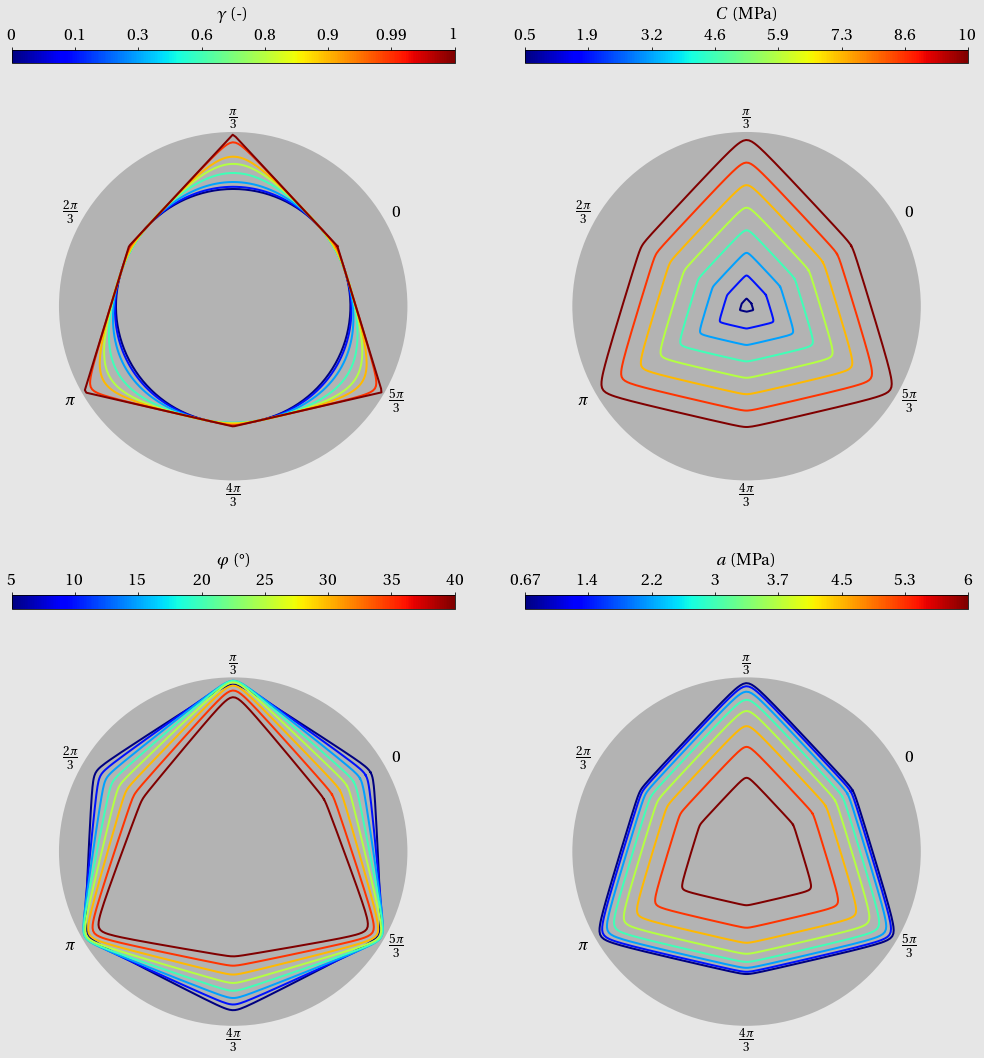

In [8]:
### >>> Array with the values for Theta
lTheta=np.linspace(0.,2.*pi,360)

### >>> Define the figure and the subplots
fig,ax=plt.subplots(2,2,subplot_kw={'projection':'polar'},figsize=(14,15))
fx=ax.flatten()

### >>> Loop on DSensi items
i=0
for p,dic in DSensi.items():
    if p!="DilationAngle":
        ### >>> Temporary dictionary for le loop
        DTmp=DefaultDicPara.copy()
        ### >>> Loop on the values of the parameter p
        j=0
        for vp in dic["list"]:
            lSeq=[]
            DTmp[p]=vp
            ### >>> Loop on Theta
            for t in lTheta:
                root=minimize_scalar(F,bounds=(0.,1.e3*DefaultDicPara["Cohesion"]),args=(0.,t,DTmp),method='bounded')
                lSeq.append(sqrt(3.*root.x))
            ### >>> Plot
            ic=float(j)/max(1.,float(len(dic["list"])-1.))
            ic=int(ic*(len(MyCMapUP)-1.))
            fx[i].plot(lTheta,lSeq,lw=2,c=MyCMapUP[ic],zorder=11)
            j+=1
        ### >>> Options for subplots axis
        fx[i].set_theta_offset(pi/6.)
        fx[i].set_xticks(np.linspace(0.,5.*pi/3.,6))
        fx[i].set_xticklabels([r"$0$",r"$\frac{\pi}{3}$",r"$\frac{2\pi}{3}$",r"$\pi$",r"$\frac{4\pi}{3}$",r"$\frac{5\pi}{3}$"])
        fx[i].set_rticks([])
        fx[i].set_facecolor('.7')
        fx[i].grid(lw=1,ls=':',c='.5',zorder=0)
        ### >>> Options for color bars
        norm=mpl.colors.Normalize(vmin=0.,vmax=1.)
        cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=MyCMap),ax=fx[i],shrink=.9,aspect=35,location="top")
        cb.set_ticks(np.linspace(0.,1.,len(dic["list"])))
        cb.set_ticklabels(['{level:.2g}'.format(level=l/dic["scale"]) for l in dic["list"]])
        t=cb.set_label(dic["label"],va="bottom")
        i+=1

### >>> Options for the figure
fig.set_facecolor('.9')

### >>> Save the figure
plt.savefig("hyperbolic_mc_fp_pi_plane_min.pdf",dpi=600,bbox_inches='tight')

__*Create plots of $F$ in the stress plane ${\left(\sigma_m,\sigma_{eq}\right)}$ for $\theta=\frac{\pi}{3}$ (compression)*__

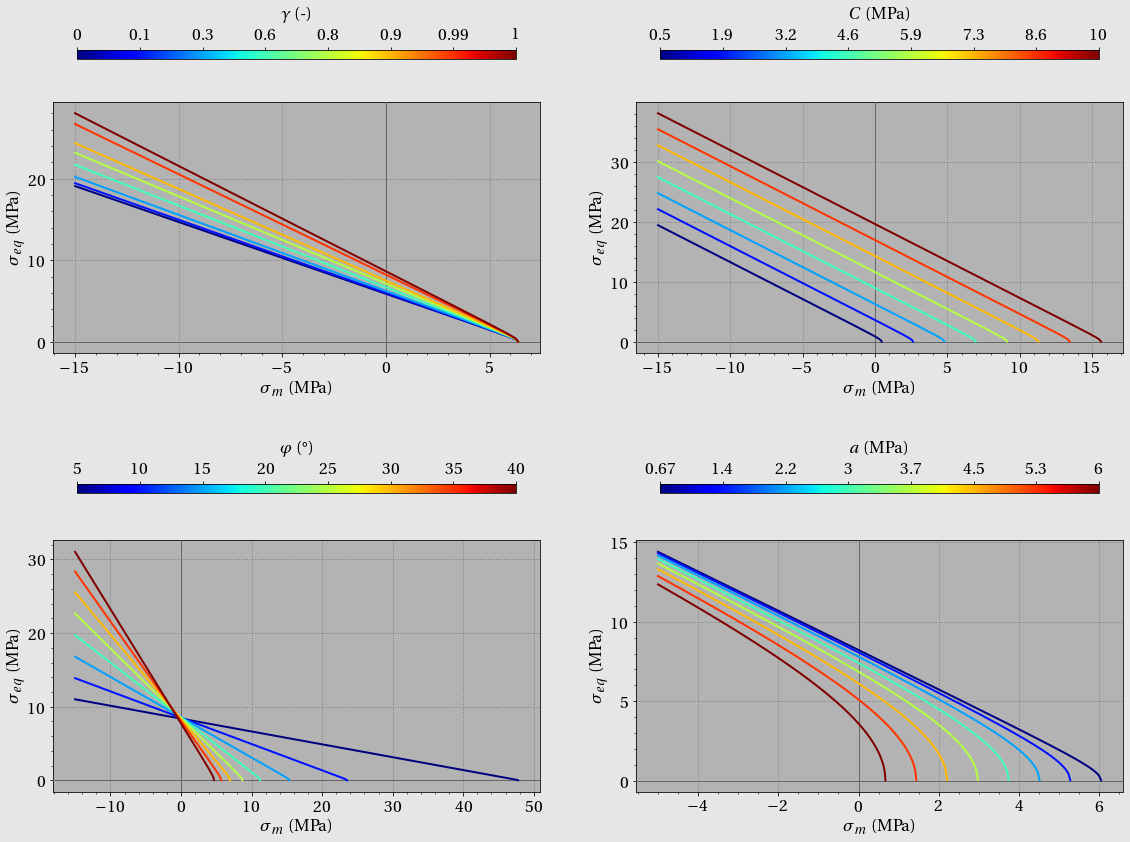

In [9]:
### >>> Define the figure and the subplots
fig,ax=plt.subplots(2,2,figsize=(16,12))
fx=ax.flatten()

### >>> Loop on DSensi items
i=0
for p,dic in DSensi.items():
    if p!="DilationAngle":
        ### >>> Temporary dictionary for le loop
        DTmp=DefaultDicPara.copy()
        ### >>> Loop on the values of the parameter p
        j=0
        for vp in dic["list"]:
            lSeq=[]
            DTmp[p]=vp
            MCT=3.*(DTmp["Cohesion"]/tan(DTmp["FrictionAngle"]*pi/180.)-DTmp["TensionCutOff"])
            if p=="TensionCutOff":
                lI1=np.linspace(-15.,.9999*MCT,250)
            else:
                lI1=np.linspace(-45.,.9999*MCT,250)
            ### >>> Loop on I1
            for I1 in lI1:
                root=minimize_scalar(F,bounds=(0.,1.e3*DefaultDicPara["Cohesion"]),args=(I1,pi/3.,DTmp),method='bounded')
                lSeq.append(sqrt(3.*root.x))
            ### >>> Plot
            ic=float(j)/max(1.,float(len(dic["list"])-1.))
            ic=int(ic*(len(MyCMapUP)-1.))
            fx[i].plot(lI1/3.,lSeq,lw=2,c=MyCMapUP[ic],zorder=10)
            j+=1
        ### >>> Options for subplots axis
        fx[i].set_xlabel(r"$\sigma_m$ (MPa)")
        fx[i].set_ylabel(r"$\sigma_{eq}$ (MPa)")
        fx[i].minorticks_on()
        fx[i].set_facecolor('.7')
        fx[i].grid(lw=1,ls=':',c='.5',zorder=0)
        fx[i].axhline(0.,lw=1,ls='-',c='.4',zorder=3)
        fx[i].axvline(0.,lw=1,ls='-',c='.4',zorder=3)
        ### >>> Options for color bars
        norm=mpl.colors.Normalize(vmin=0.,vmax=1.)
        cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=MyCMap),ax=fx[i],shrink=.9,aspect=35,location="top")
        cb.set_ticks(np.linspace(0.,1.,len(dic["list"])))
        cb.set_ticklabels(['{level:.2g}'.format(level=l/dic["scale"]) for l in dic["list"]])
        t=cb.set_label(dic["label"],va="bottom")
        i+=1

### >>> Options for the figure
fig.set_facecolor('.9')

### >>> Save the figure
plt.savefig("hyperbolic_mc_fp_stress_plane_min.pdf",dpi=600,bbox_inches='tight')

__*Create plots of $G$ in the $\pi$ plane for $I_1\equiv 0$*__

In [ ]:
### >>> Array with the values for Theta
lTheta=np.linspace(0.,2.*pi,600)

### >>> Define the figure and the subplots
fig,ax=plt.subplots(2,3,subplot_kw={'projection':'polar'},figsize=(20,15))
fx=ax.flatten()

### >>> Loop on DSensi items
i=0
for p,dic in DSensi.items():
    ### >>> Temporary dictionary for le loop
    DTmp=DefaultDicPara.copy()
    ### >>> Loop on the values of the parameter p
    j=0
    for vp in dic["list"]:
        lSeq=[]
        DTmp[p]=vp
        ### >>> Loop on Theta
        for t in lTheta:
            root=minimize_scalar(G,bounds=(0.,1.e3*DefaultDicPara["Cohesion"]),args=(0.,t,DTmp),method='bounded')
            lSeq.append(sqrt(3.*root.x))
        ### >>> Plot
        ic=float(j)/max(1.,float(len(dic["list"])-1.))
        ic=int(ic*(len(MyCMapUP)-1.))
        fx[i].plot(lTheta,lSeq,lw=2,c=MyCMapUP[ic])
        j+=1
    ### >>> Options for subplots axis
    fx[i].set_theta_offset(pi/6.)
    fx[i].set_xticks(np.linspace(0.,5.*pi/3.,6))
    fx[i].set_xticklabels([r"$0$",r"$\frac{\pi}{3}$",r"$\frac{2\pi}{3}$",r"$\pi$",r"$\frac{4\pi}{3}$",r"$\frac{5\pi}{3}$"])
    fx[i].set_rticks([])
    fx[i].set_facecolor('.7')
    fx[i].grid(lw=1,ls=':',c='.5',zorder=0)
    ### >>> Options for color bars
    norm=mpl.colors.Normalize(vmin=0.,vmax=1.)
    cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=MyCMap),ax=fx[i],shrink=.9,aspect=35,location="top")
    cb.set_ticks(np.linspace(0.,1.,len(dic["list"])))
    cb.set_ticklabels(['{level:.2g}'.format(level=l/dic["scale"]) for l in dic["list"]])
    t=cb.set_label(dic["label"],va="bottom")
    i+=1

### >>> Options for the figure
fig.set_facecolor('.9')
fx[-1].set_visible(False)

### >>> Save the figure
plt.savefig("hyperbolic_mc_gp_pi_plane_min.pdf",dpi=600,bbox_inches='tight')

__*Create plots of $G$ in the stress plane ${\left(\sigma_m,\sigma_{eq}\right)}$ for $\theta=\frac{\pi}{3}$ (compression)*__

In [ ]:
### >>> Define the figure and the subplots
fig,ax=plt.subplots(2,3,figsize=(20,12))
fx=ax.flatten()

### >>> Loop on DSensi items
i=0
for p,dic in DSensi.items():
    ### >>> Temporary dictionary for le loop
    DTmp=DefaultDicPara.copy()
    ### >>> Loop on the values of the parameter p
    j=0
    for vp in dic["list"]:
        lSeq=[]
        DTmp[p]=vp
        MCT=3.*(DTmp["Cohesion"]/tan(DTmp["DilationAngle"]*pi/180.)-DTmp["TensionCutOff"]*tan(DTmp["FrictionAngle"]*pi/180.)/tan(DTmp["DilationAngle"]*pi/180.))
        if p=="TensionCutOff":
            lI1=np.linspace(-15.,.9999*MCT,250)
        else:
            lI1=np.linspace(-45.,.9999*MCT,250)
        ### >>> Loop on lI1
        for I1 in lI1:
            root=minimize_scalar(G,bounds=(0.,1.e3*DefaultDicPara["Cohesion"]),args=(I1,pi/3.,DTmp),method='bounded')
            lSeq.append(sqrt(3.*root.x))
        ### >>> Plot
        ic=float(j)/max(1.,float(len(dic["list"])-1.))
        ic=int(ic*(len(MyCMapUP)-1.))
        fx[i].plot(lI1/3.,lSeq,lw=2,c=MyCMapUP[ic],zorder=10)
        j+=1
    ### >>> Options for subplots axis
    fx[i].set_xlabel(r"$\sigma_m$ (MPa)")
    fx[i].set_ylabel(r"$\sigma_{eq}$ (MPa)")
    fx[i].minorticks_on()
    fx[i].set_facecolor('.7')
    fx[i].grid(lw=1,ls=':',c='.5',zorder=0)
    fx[i].axhline(0.,lw=1,ls='-',c='.4',zorder=3)
    fx[i].axvline(0.,lw=1,ls='-',c='.4',zorder=3)
    ### >>> Options for color bars
    norm=mpl.colors.Normalize(vmin=0.,vmax=1.)
    cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=MyCMap),ax=fx[i],shrink=.9,aspect=35,location="top")
    cb.set_ticks(np.linspace(0.,1.,len(dic["list"])))
    cb.set_ticklabels(['{level:.2g}'.format(level=l/dic["scale"]) for l in dic["list"]])
    t=cb.set_label(dic["label"],va="bottom")
    i+=1

### >>> Options for the figure
fig.set_facecolor('.9')
fx[-1].set_visible(False)

### >>> Save the figure
plt.savefig("hyperbolic_mc_gp_stress_plane_min.pdf",dpi=600,bbox_inches='tight')